In [3]:
import sys
import geopandas as gpd
import pandas as pd
import xarray as xr
#import rasterio
import math
#from rasterstats import zonal_stats
#import pycountry
import numpy as np
#import pytz

#sys.path.append('../data/automatic/when2heat/')
#from scripts import demand, read, preprocess, misc


sys.path.append('../src/construct/')
import util

population = '../land-eligibility/build/eurospores/population.csv'
population_tif = '../land-eligibility/build/population-europe.tif'
units = '/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/eurospores/units.geojson'
annual_demand = "../build/annual_heat_demand.csv"
dwellings = "../data/automatic/dwellings.tsv.gz"
model_year = 2016

EPSG_3035_PROJ4 = "+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs "
WGS84 = "EPSG:4326"

idx = pd.IndexSlice

In [2]:
def map_to_merra2(population, air_temp, units):
    # Get population per merra-2 site id and country
    europe_shape = gpd.read_file(units)
    if isinstance(europe_shape.crs, dict):
        europe_shape.crs = europe_shape.crs['init']  # {'init': '...'} is deprecated

    coords = air_temp[['lat', 'lon']].to_dataframe()

    points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(coords.lon.values, coords.lat.values),
        index=coords.index, crs=WGS84
    )
    points_m = points.to_crs(EPSG_3035_PROJ4)
    polys_m = gpd.GeoDataFrame(
        index=points_m.index, geometry=points_m.buffer(25000).envelope  # 50km horizontal resolution
    )
    polys_eu = gpd.overlay(polys_m.to_crs(WGS84).reset_index(), europe_shape.to_crs(WGS84))

    with rasterio.open(population) as src:
        array = src.read(1)
        crs = src.crs
        affine = src.transform

        pop_polys = zonal_stats(polys_eu.to_crs(crs), array, affine=affine, stats='sum', nodata=0)
        polys_eu['population'] = [i['sum'] for i in pop_polys]

        pop_eu = zonal_stats(europe_shape.to_crs(crs), array, affine=affine, stats='sum', nodata=0)
        europe_shape['population'] = [i['sum'] for i in pop_eu]

    assert math.isclose(
        europe_shape.population.sum(), polys_eu.population.sum(), abs_tol=10**3
    )

    return polys_eu.set_index('site').drop(columns=['name', 'type', 'proper'])
mapped_pop = map_to_merra2(population_tif, xr.open_dataset('../data/weather/temperature.nc'), units)
mapped_pop['longitude'] = mapped_pop.centroid.x
mapped_pop['latitude'] = mapped_pop.centroid.y

In [3]:
def scale_national_annual_demand(mapped_pop, annual_demand, model_year):
    """
    Re-scale demand data normalised against national population according to
    population of considered spatial resolution
    """
    national_annual_demand_ratio = pd.read_csv(annual_demand, index_col=[0, 1]).fillna(0)
    population_df = mapped_pop.set_index(['id', 'country_code']).population.groupby(level=[0, 1]).sum()
    scaled_annual_demand = (
        national_annual_demand_ratio
        .xs(model_year, level='year')
        .align(population_df, axis=0, level='country_code')[0]
        .mul(population_df, axis=0)
        .reset_index('country_code', drop=True)
        .stack()
    )

    return scaled_annual_demand

scaled_annual_demand = scale_national_annual_demand(mapped_pop, annual_demand, model_year)

In [4]:
def prep_weather_data(filepath, variable, model_year, mapped_pop):
    _ds = xr.open_dataset(filepath).loc[{'time': str(model_year)}]
    _df = _ds[variable].to_pandas()
    _df = _df.loc[mapped_pop.index].assign(latitude=mapped_pop.latitude, longitude=mapped_pop.longitude, country=mapped_pop.id).set_index(['country', 'latitude', 'longitude'])
    _df.columns = pd.to_datetime(_df.columns)
    
    return _df.T

In [5]:
air_temp = (prep_weather_data('../data/weather/temperature.nc', 'temperature', model_year, mapped_pop) + 273.15)
#soil_temp = (prep_weather_data('../data/weather/tsoil5.nc', 'soil_temperture_5', model_year, mapped_pop) + 273.15).filter(regex='AUT|CHE|GRC|GBR')
wind_speed = (prep_weather_data('../data/weather/wind10m.nc', 'wind_speed', model_year, mapped_pop))

In [6]:
ref_temp = demand.reference_temperature(air_temp)

In [7]:
daily_params = read.daily_parameters('../data/automatic/when2heat/input/')
wind = wind_speed.mean()
daily_heat = demand.daily_heat(ref_temp, 
                               wind, 
                               daily_params)

In [8]:
daily_water = demand.daily_water(ref_temp,
                                 wind,
                                 daily_params)

In [9]:
hourly_parameters = read.hourly_parameters('../data/automatic/when2heat/input/')

In [10]:
hourly_heat = demand.hourly_heat(daily_heat,
                                 ref_temp, 
                                 hourly_parameters)

KeyboardInterrupt: 

In [ ]:
hourly_water = demand.hourly_water(daily_water,
                                   ref_temp, 
                                   hourly_parameters)

In [11]:
heat_ref = misc.upsample_df((np.ceil(((ref_temp - 273.15) / 5).astype('float64')) * 5).clip(lower=-15, upper=30), '60min')
water_ref = misc.upsample_df(pd.DataFrame(30, index=ref_temp.index, columns=ref_temp.columns), '60min')

upsampled_daily_heat = misc.upsample_df(daily_heat, '60min')
upsampled_daily_water = misc.upsample_df(daily_water, '60min')

In [13]:
hourly_parameters['SFH'].columns = hourly_parameters['SFH'].columns.astype(int)
hourly_parameters['MFH'].columns = hourly_parameters['MFH'].columns.astype(int)
hourly_parameters['COM'].columns = hourly_parameters['COM'].columns.astype(int)

new_time = upsampled_daily_heat.index.map(lambda i: i.strftime('%H:%M'))
time_and_weekdays = pd.MultiIndex.from_arrays([upsampled_daily_heat.index.dayofweek, new_time], names=['weekday', 'time'])

def hourly_profile(x, _ref):
    building_type = x.name[0]
    if building_type == 'COM':
        return x.mul(hourly_parameters[building_type].lookup(time_and_weekdays, _ref[x.name[1:]].values))
    else:
        return x.mul(hourly_parameters[building_type].lookup(new_time, _ref[x.name[1:]].values))

hourly_heat = upsampled_daily_heat.apply(hourly_profile, _ref=heat_ref) 
hourly_water = upsampled_daily_water.apply(hourly_profile, _ref=water_ref) 

In [17]:
hourly_space = (hourly_heat - hourly_water).clip(lower=0)

In [28]:
def get_dwelling_ratio(path_to_dwellings, mapped_pop):
    dwellings = pd.read_csv(path_to_dwellings, delimiter='\t', index_col=0)
    dwellings.columns = dwellings.columns.str.strip()
    country_dwelling_info = dwellings.filter(regex="^[A-Z]{2}$")
    countries_SFH = country_dwelling_info.loc["DW,RES1,NR,2011"].astype(float)
    countries_MFH = country_dwelling_info.loc[["DW,RES2,NR,2011", "DW,RES_GE3,NR,2011"]].astype(float).sum()
    
    MFH_to_SFH = countries_MFH / (countries_SFH + countries_MFH)
    MFH_to_SFH.index = MFH_to_SFH.index.map(util.get_alpha3)
    
    # extend index from countries to eurospores regions
    ids = mapped_pop.set_index('country_code').id.drop_duplicates()
    MFH_to_SFH = MFH_to_SFH.reindex(ids.index)
    MFH_to_SFH.index = ids.values
    
    # fill empties
    print('Filling missing regions {} with average dwelling ratio'.format(MFH_to_SFH[MFH_to_SFH.isnull()].index.values))
    MFH_to_SFH = MFH_to_SFH.fillna(MFH_to_SFH.mean())
    
    return MFH_to_SFH

dwelling_ratio = get_dwelling_ratio(dwellings, mapped_pop)

Filling missing regions ['HRV_1' 'BIH_1' 'SRB_1' 'MNE_1' 'ALB_1' 'MKD_1'] with average dwelling ratio


In [15]:
site_pop = mapped_pop[['population', 'longitude', 'latitude']].set_index(['latitude', 'longitude']).population

In [29]:
def wavg(x):
    weighted_avg = np.average(x, weights=site_pop.reindex(x.droplevel((0, 1), axis=1).columns).fillna(0), axis=1)
    return pd.Series(data=weighted_avg, index=x.index)

def shift_profiles(x):
    model_year = x.index.year.unique().item()
    country = pycountry.countries.lookup(x.name.split('_')[0]).alpha_2
    tz = pytz.country_timezones[country][0]
    try:
        idx = x.index.tz_localize(tz, nonexistent='shift_forward').tz_convert('UTC')
    except pytz.AmbiguousTimeError as err:
        idx = x.index.tz_localize(tz, ambiguous=x.index != err.args[0], nonexistent='shift_forward').tz_convert('UTC')
    shift = len(idx[idx.year > model_year]) - len(idx[idx.year < model_year])

    x = pd.Series(data=np.roll(x, shift=shift), index=x.index)
    
    return x

results = {}
for k, v in {'space_heating': hourly_space, 'water_heating': hourly_water}.items():
    regional_hourly = v.groupby(level=['country', 'building'], axis=1).apply(wavg)
    residential_hourly = (
        (regional_hourly.xs('SFH', level='building', axis=1).mul(1 - dwelling_ratio))
        .add(regional_hourly.xs('MFH', level='building', axis=1).mul(dwelling_ratio))
        .dropna(axis=1, how='all') 
        .apply(lambda x: x * scaled_annual_demand[idx[x.name, k]] / x.sum())
    )
    commercial_hourly = (
        regional_hourly.xs('COM', level='building', axis=1)
        .apply(lambda x: x * scaled_annual_demand[idx[x.name, f'commercial_{k}']] / x.sum())
    )
    results[k] = residential_hourly.add(commercial_hourly).apply(shift_profiles)

In [33]:
results['space_heating'].filter(regex='AUT').sum().sum()

63.43502289782302

In [50]:
regional_hourly = hourly_space.groupby(level=['country', 'building'], axis=1).apply(wavg)
((regional_hourly.xs('SFH', level='building', axis=1).mul(1 - dwelling_ratio))
        .add(regional_hourly.xs('MFH', level='building', axis=1).mul(dwelling_ratio))
        .dropna(axis=1, how='all') ).sum()

ALB_1    155.073724
AUT_1    395.947811
AUT_2    319.389081
AUT_3    290.310608
BEL_1    264.421431
            ...    
SVN_1    284.212550
SWE_1    513.492257
SWE_2    455.066818
SWE_3    356.510036
SWE_4    311.476128
Length: 98, dtype: float64

In [62]:
foo = ((regional_hourly.xs('SFH', level='building', axis=1).mul(1 - dwelling_ratio))
        .add(regional_hourly.xs('MFH', level='building', axis=1).mul(dwelling_ratio))
        .dropna(axis=1, how='all') )
foo.apply(lambda x: x * scaled_annual_demand[idx[x.name, 'space_heating']] / x.sum()).filter(regex='AUT').sum().sum()

48.49071087110707

In [63]:
(
        regional_hourly.xs('COM', level='building', axis=1)
        .apply(lambda x: x * scaled_annual_demand[idx[x.name, f'commercial_space_heating']] / x.sum())
    ).filter(regex='AUT').sum().sum()

14.944312026716172

In [360]:
foo = all_hourly.copy(deep=True)

def bar(x, ambiguous=None):
    x.index = x.index.tz_localize('Europe/Athens', ambiguous='NaT', nonexistent='shift_forward')
    return x

In [361]:
baz = bar(foo).tz_convert('UTC')
baz.loc['2016-03-24']

,AUT_1,AUT_2,AUT_3,CHE_1,CHE_2
time,,,,,
2016-03-24 00:00:00+00:00,0.000182,0.000249,0.000334,0.000614,0.000078
2016-03-24 01:00:00+00:00,0.000186,0.000255,0.000341,0.000620,0.000079
2016-03-24 02:00:00+00:00,0.000299,0.000410,0.000549,0.000971,0.000123
2016-03-24 03:00:00+00:00,0.000498,0.000682,0.000911,0.001557,0.000198
2016-03-24 04:00:00+00:00,0.000544,0.000746,0.000994,0.001653,0.000210
2016-03-24 05:00:00+00:00,0.000573,0.000785,0.001048,0.001767,0.000224
2016-03-24 06:00:00+00:00,0.000472,0.000646,0.000863,0.001452,0.000185
2016-03-24 07:00:00+00:00,0.000463,0.000634,0.000848,0.001422,0.000181
2016-03-24 08:00:00+00:00,0.000437,0.000599,0.000800,0.001351,0.000172


In [406]:
foo.index.isin(['2016-10-30 03:00:00', '2016-03-27 03:00:00'])

array([False, False, False, ..., False, False, False])

,AUT_1,AUT_2,AUT_3,CHE_1,CHE_2
time,,,,,
2016-01-01 00:00:00,0.000174,0.000238,0.000319,0.000578,0.000073
2016-01-01 01:00:00,0.000186,0.000255,0.000342,0.000623,0.000079
2016-01-01 02:00:00,0.000182,0.000249,0.000333,0.000612,0.000078
2016-01-01 03:00:00,0.000184,0.000252,0.000337,0.000612,0.000078
2016-01-01 04:00:00,0.000293,0.000401,0.000538,0.000945,0.000120
...,...,...,...,...,...
2016-12-31 19:00:00,0.000382,0.000524,0.000700,0.001138,0.000145
2016-12-31 20:00:00,0.000405,0.000555,0.000742,0.001204,0.000153
2016-12-31 21:00:00,0.000388,0.000531,0.000710,0.001171,0.000149


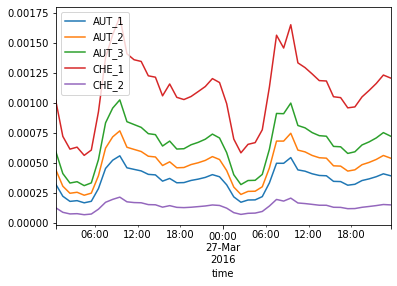

In [492]:
foo = all_hourly.copy(deep=True)
foo.index = foo.index.tz_localize('America/St_Johns', ambiguous=foo.index != '2016-10-30 03:00:00', nonexistent='shift_backward').tz_convert('UTC')
foo.loc[slice('2016-03-26', '2016-03-27')].plot()

In [493]:
foo.index[foo.index.year < 2016]

DatetimeIndex(['2017-01-01 00:30:00+00:00', '2017-01-01 01:30:00+00:00',
               '2017-01-01 02:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', freq='60T')

In [471]:
foo.reset_index()[foo.index.isnull()]#foo.index.where(foo.index == 'NaT', other=0)

,time,AUT_1,AUT_2,AUT_3,CHE_1,CHE_2


In [491]:
pytz.country_timezones['CA'][0]

'America/St_Johns'

In [495]:
foo['AUT_1'].apply(np.roll, shift=2)

time
2016-01-01 03:30:00+00:00    0.000174
2016-01-01 04:30:00+00:00    0.000186
2016-01-01 05:30:00+00:00    0.000182
2016-01-01 06:30:00+00:00    0.000184
2016-01-01 07:30:00+00:00    0.000293
                               ...   
2016-12-31 22:30:00+00:00    0.000382
2016-12-31 23:30:00+00:00    0.000405
2017-01-01 00:30:00+00:00    0.000388
2017-01-01 01:30:00+00:00    0.000321
2017-01-01 02:30:00+00:00    0.000220
Freq: 60T, Name: AUT_1, Length: 8784, dtype: float64

In [514]:
np.roll(foo['AUT_1'], shift=-1)

array([0.00018633, 0.00018151, 0.00018402, ..., 0.00032076, 0.00022036,
       0.00017361])

In [56]:
cooking = pd.read_csv('../data/cooking_profiles.csv.gz', index_col=[0, 1, 2], parse_dates=[0], squeeze=True)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [33]:
annual_demand = pd.read_csv('../build/eurospores/annual_demand.csv', index_col=[0, 1, 2, 3, 4, 5], squeeze=True)

In [35]:
units = gpd.read_file('../build/units.geojson')

In [37]:
eurospore_to_country = units.set_index('id').country_code

In [59]:
annual_cooking = annual_demand.xs(('heat_demand', 'cooking'), level=('dataset', 'end_use')).sum(level=['year', 'id'])
annual_cooking = (
    pd.merge(
        annual_cooking.to_frame('cooking_profile'), 
        eurospore_to_country.to_frame('country_code'), 
        left_index=True, right_index=True
    )
    .set_index('country_code', append=True)
)
df = pd.merge(cooking, annual_cooking, left_index=True, right_index=True)
hourly_cooking = df['cooking_profile'].mul(df['cooking'])
hourly_cooking = hourly_cooking.droplevel(['year', 'country_code']).unstack()

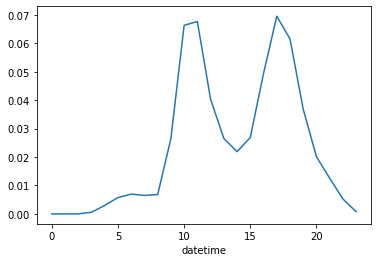

In [71]:
hourly_cooking.sum(axis=1).groupby([hourly_cooking.index.hour]).mean().plot()

In [68]:
pd.Timegrouper.dayofyear

AttributeError: module 'pandas' has no attribute 'Timegrouper'